In [65]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(ggplot2)

In [66]:
colname = c("Vmag","distance","error_distance","color_index","spectral_type","Amag","Class")
stars <- read_csv("stars.csv", col_names = colname, skip = 1)
stars

Rows: 3642 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): spectral_type
dbl (6): Vmag, distance, error_distance, color_index, Amag, Class

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Vmag,distance,error_distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
5.99,13.73,0.58,1.318,K5III,16.67835,0
8.70,2.31,1.29,-0.045,B1II,15.51806,0
5.77,5.50,1.03,0.855,G5III,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.11,2.42,0.79,1.664,M0/M1IIICNp,13.02908,0
7.94,4.94,2.90,0.210,A5V,16.40864,1
8.81,1.87,1.23,1.176,K1/K2III,15.16921,0


In [67]:
stars <- stars |>
    mutate(spectral_type = as_factor(spectral_type))
stars

Vmag,distance,error_distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5.99,13.73,0.58,1.318,K5III,16.67835,0
8.70,2.31,1.29,-0.045,B1II,15.51806,0
5.77,5.50,1.03,0.855,G5III,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.11,2.42,0.79,1.664,M0/M1IIICNp,13.02908,0
7.94,4.94,2.90,0.210,A5V,16.40864,1
8.81,1.87,1.23,1.176,K1/K2III,15.16921,0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


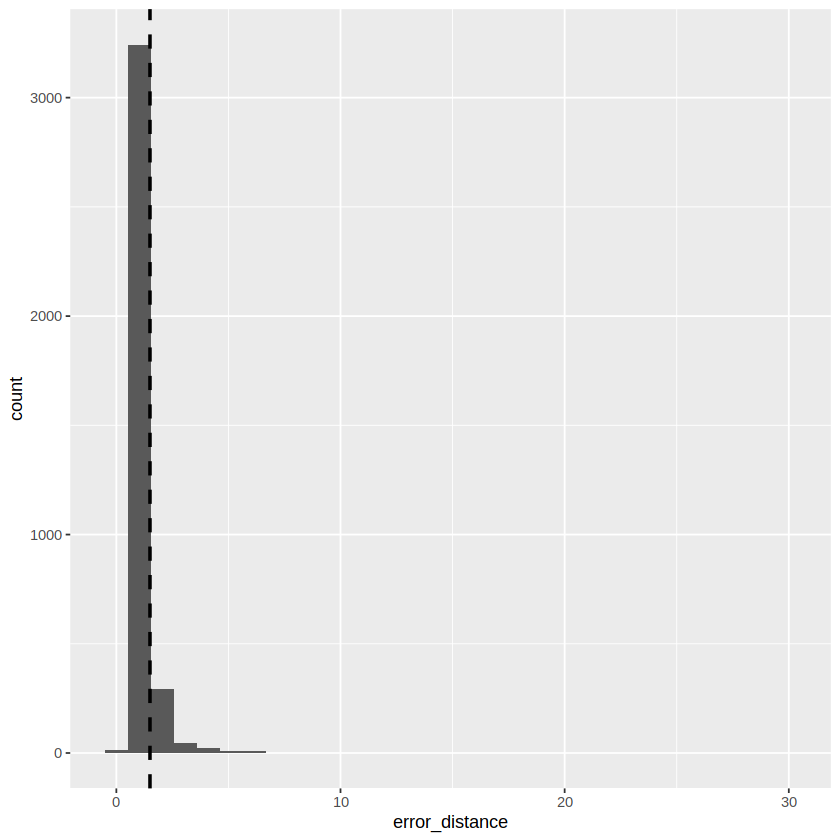

In [68]:
error_remove_plot <- stars |>
    ggplot(aes(x = error_distance)) + 
    geom_histogram() +
    geom_vline(xintercept = 1.50, linetype = "dashed", linewidth = 1)

error_remove_plot
# this plot shows the number of error values for the distance. The values left of the vertical line 
# will be kept and the values to the right will be discarded.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


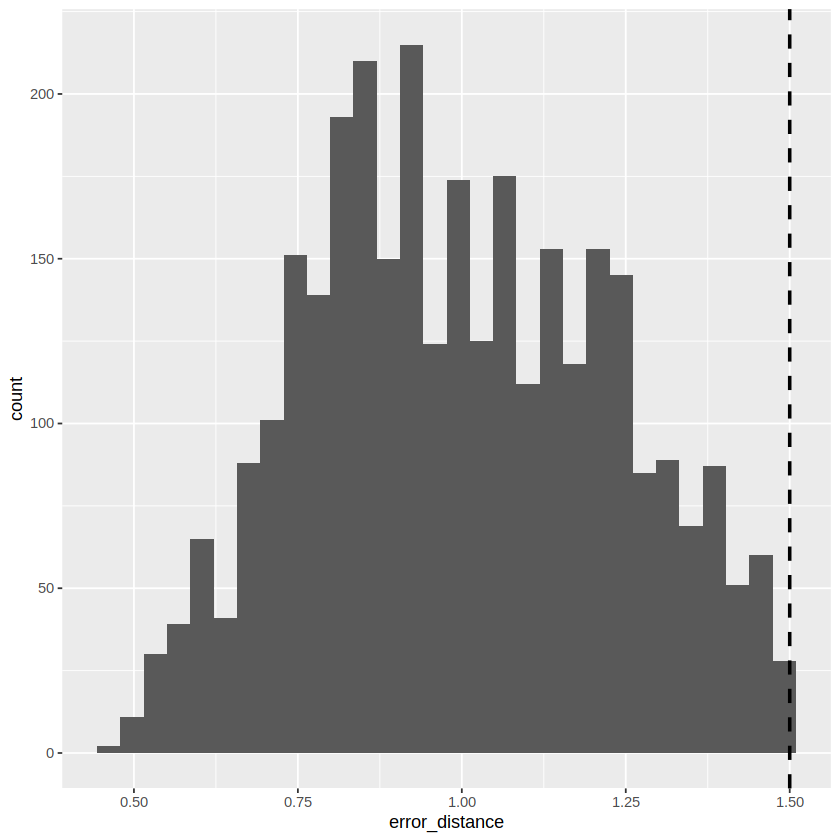

In [69]:
final_error_plot <- stars |>
    filter(error_distance < 1.50) |>
    ggplot(aes(x = error_distance)) + 
    geom_histogram() +
    geom_vline(xintercept = 1.50, linetype = "dashed", linewidth = 1)
final_error_plot

In [71]:
# the dataset will be adjusted according to the information found above
#after the error distance is used to remove data points, the column has no further use.


stars <- stars |>
    filter(error_distance < 1.50)
    select( Vmag, distance, color_index, spectral_typr, Amag ,Class)
stars


ERROR: Error in select(Vmag, distance, color_index, spectral_typr, Amag, Class): object 'Vmag' not found
